In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from tensorflow.keras.layers import Dense, MaxPooling1D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.random import set_seed
from tensorflow.keras.callbacks import EarlyStopping
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
heart = pd.read_csv('./data/heart.csv')

## Introduction

### In this project, we will use a dataset of patients to predict the presence of heart disease, which is a binary classification problem. The explanations of all the variables in this dataset are listed below. We will build three supervised learning models including logistic regression, random forest, and neural network. Moreover, we will use unsupervised models such as PCA and K-means to do dimensionality reduction and clustering respectively.

* **Features**:
1. age: age in years
2. sex:
    * 0: Female
    * 1: Male
3. cp: chest pain type
    * 0: Typical angina: chest pain related decrease blood supply to the heart
    * 1: Atypical angina: chest pain not related to heart
    * 2: Non-anginal pain: typically esophageal spasms (non heart related)
    * 3: Asymptomatic: chest pain not showing signs of disease
4. trestbps: resting blood pressure (in mm Hg on admission to the hospital)
5. chol: serum cholestoral in mg/dl
6. fbs: fasting blood sugar > 120 mg/dl
    * 0: False
    * 1: True
7. restecg: resting electrocardiographic results
    * 0: Nothing to note
    * 1: ST-T Wave abnormality
    * 2: Possible or definite left ventricular hypertrophy
8. thalach: maximum heart rate achieved
9. exang: exercise induced angina
    * 0: False
    * 1: True
10. oldpeak: ST depression induced by exercise relative to rest
11. slope: the slope of the peak exercise ST segment
    * 0: Upsloping: better heart rate with excercise (uncommon)
    * 1: Flatsloping: minimal change (typical healthy heart)
    * 2: Downslopins: signs of unhealthy heart
12. ca: number of major vessels (0-3) colored by flourosopy
13. thal: thalium stress result
    * 3: Normal
    * 6: Fixed defect
    * 7: Reversable defect
* **Output**:
14. target: have disease or not
    * 0: No
    * 1: Yes

In [4]:
heart.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,1,145,233,1,2,150,0,2.3,3,0,6,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3,3,1
2,67,1,4,120,229,0,2,129,1,2.6,2,2,7,1
3,37,1,3,130,250,0,0,187,0,3.5,3,0,3,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0,3,0


## Data Cleaning

### We have checked that there is no null cell in the dataset but we notice that the dtype of features "ca" and "thal" is object. Upon further checking, there are 6 samples that contain invalid data '?' rather than a numerical value, which accounts for 2% of the total. Since this number is quite small, we can opt to remove these samples from our dataset.

In [5]:
heart.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    object 
 12  thal      303 non-null    object 
 13  target    303 non-null    int64  
dtypes: float64(1), int64(11), object(2)
memory usage: 33.3+ KB


In [6]:
invalid = heart[~((heart.ca.str.isnumeric())&(heart.thal.str.isnumeric()))]
invalid

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
87,53,0,3,128,216,0,2,115,0,0.0,1,0,?,0
166,52,1,3,138,223,0,0,169,0,0.0,1,?,3,0
192,43,1,4,132,247,1,2,143,1,0.1,2,?,7,1
266,52,1,4,128,204,1,0,156,1,1.0,2,0,?,1
287,58,1,2,125,220,0,0,144,0,0.4,2,?,7,0
302,38,1,3,138,175,0,0,173,0,0.0,1,?,3,0


In [7]:
heart.drop(invalid.index.values,inplace=True)

### Some of the features are essentially categorical based on the definition so we would like to convert their dtype to object. This is to facilitate data analysis later on.

In [8]:
cat_cols = [['sex','cp','fbs','restecg','exang','slope','ca','thal']]

for col in cat_cols:
    heart[col] = heart[col].astype('object')

In [9]:
heart.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 297 entries, 0 to 301
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       297 non-null    int64  
 1   sex       297 non-null    object 
 2   cp        297 non-null    object 
 3   trestbps  297 non-null    int64  
 4   chol      297 non-null    int64  
 5   fbs       297 non-null    object 
 6   restecg   297 non-null    object 
 7   thalach   297 non-null    int64  
 8   exang     297 non-null    object 
 9   oldpeak   297 non-null    float64
 10  slope     297 non-null    object 
 11  ca        297 non-null    object 
 12  thal      297 non-null    object 
 13  target    297 non-null    int64  
dtypes: float64(1), int64(5), object(8)
memory usage: 34.8+ KB


## Univariate Analysis

### We use one numerical variable and one categorical variable as examples of univariate analysis. In general, for a numerical variable, a histogram can tell us an overview of the data. For a categorical variable, we are more interested to know the percentage of each class.

#### The age of patients ranges from 29 to 77 with mean around 55. The middle 50% is between 48 and 61.

count    297.000000
mean      54.542088
std        9.049736
min       29.000000
25%       48.000000
50%       56.000000
75%       61.000000
max       77.000000
Name: age, dtype: float64

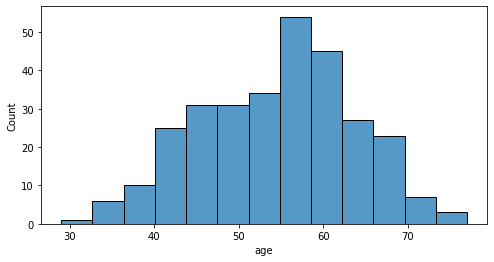

In [10]:
fig,ax = plt.subplots(figsize=(8,4))
sns.histplot(x='age',data=heart)
heart.age.describe()

#### In our dataset, about 46% of the patients have a heart disease.

0    160
1    137
Name: target, dtype: int64

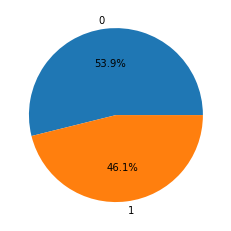

In [11]:
plt.pie(heart.target.value_counts().values,labels=heart.target.value_counts().index,autopct='%1.1f%%')
heart.target.value_counts()

## Bivariate Analysis

### For bivariate analysis, the methodology we use mainly depends on the type of variables (whether numerical or categorical). 
### For two numerical variables, we can compute the correlation coefficient and know whether they are positively or negetively correlated. 

#### The heatmap below shows us the correlation between two numerical features, from which we can tell there exist some trends in the dataset. For example, the elderly are more likely to have higher resting blood pressure (cor=0.29), and lower maximum heart rate (cor=-0.39). But in general, the correlation is not strong enough. 

#### We can also find the correlation between a numerical feature and the "target" in the heatmap. For example, the negative correlation coefficient of "thalach" and "target" means if a person can reach a higher heart rate, he is less likely to have a heart disease.

<AxesSubplot:>

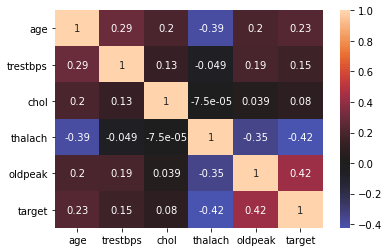

In [12]:
fig,ax = plt.subplots(figsize=(6,4))
sns.heatmap(heart.corr(),center=0,annot=True)

### For two categorical variables, we can use a contingency table or a bar chart to show the population for each class combination. 

#### (a) - Male patients are more likely to have a heart disease than female.

#### (b) - The patients with chest pain type I/II/III ("cp"=1,2,3) have a lower chance of heart disease. For the patients with chest pain type IV ("cp"=4), they are more likely to have a heart disease. 

#### (c) - There is no strong relation between fasting blood sugar and presence of heart disease. But most patients in general do not have a high fasting blood sugar issue.

#### (d) - The majority of resting electrocardiographic results is 0 or 2. Patients with "restecg"=2 have a higher risk of heart disease than those with "restecg"=0.

Text(0.5, 1.0, '(d) - resting electrocardiographic')

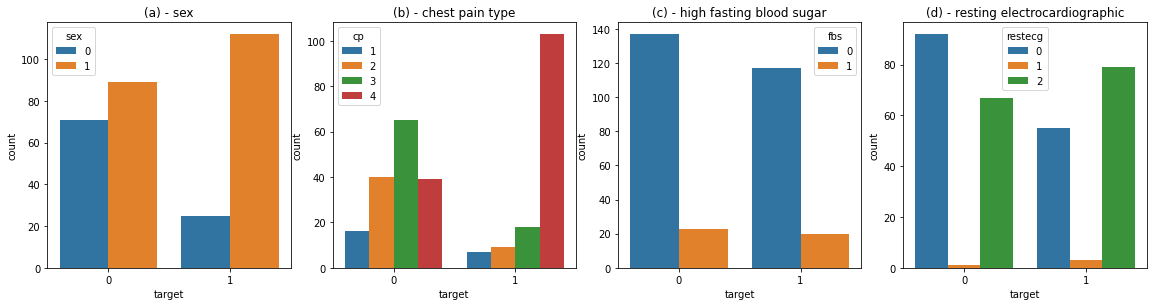

In [13]:
fig,ax = plt.subplots(1,4,figsize=(16,4))
fig.tight_layout()
sns.countplot(x='target',hue='sex',data=heart,ax=ax[0])
sns.countplot(x='target',hue='cp',data=heart,ax=ax[1])
sns.countplot(x='target',hue='fbs',data=heart,ax=ax[2])
sns.countplot(x='target',hue='restecg',data=heart,ax=ax[3])
ax[0].set_title('(a) - sex')
ax[1].set_title('(b) - chest pain type')
ax[2].set_title('(c) - high fasting blood sugar')
ax[3].set_title('(d) - resting electrocardiographic')

#### (e) - The patients have exercise induced angina ("exang"=1) are more likely to have a heart disease.

#### (f) - The patients whose slope of the peak exercise ST segment is 2 or 3 are more likely to have a heart disease.

#### (g) - The patients with higher "ca" have a higher risk of heart disease. 

#### (h) - The majority of "thal" is 3 and 7. The patients with "ca"=6,7 are more likely to have a heart disease than those with "ca"=3.

Text(0.5, 1.0, '(h) - thalium stress')

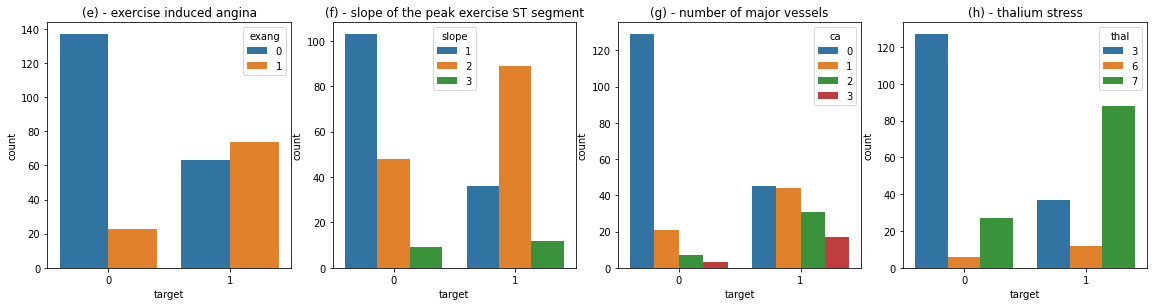

In [14]:
fig,ax = plt.subplots(1,4,figsize=(16,4))
fig.tight_layout()
sns.countplot(x='target',hue='exang',data=heart,ax=ax[0])
sns.countplot(x='target',hue='slope',data=heart,ax=ax[1])
sns.countplot(x='target',hue='ca',data=heart,ax=ax[2],hue_order=sorted(heart.ca.unique()))
sns.countplot(x='target',hue='thal',data=heart,ax=ax[3],hue_order=sorted(heart.thal.unique()))
ax[0].set_title('(e) - exercise induced angina')
ax[1].set_title('(f) - slope of the peak exercise ST segment')
ax[2].set_title('(g) - number of major vessels')
ax[3].set_title('(h) - thalium stress')

### For two variables of different type, a boxplot would be useful to tell whether the behaviour of two classes is same.

#### (i) - The elderly have a higher risk of heart disease.

#### (j) - The patients with heart disease tend to have a slightly higher resting blood pressure but the difference is not obvious.

#### (k) - High serum cholestoral might lead to heart disease but the evidence is weak.

Text(0.5, 1.0, '(k) - serum cholestoral')

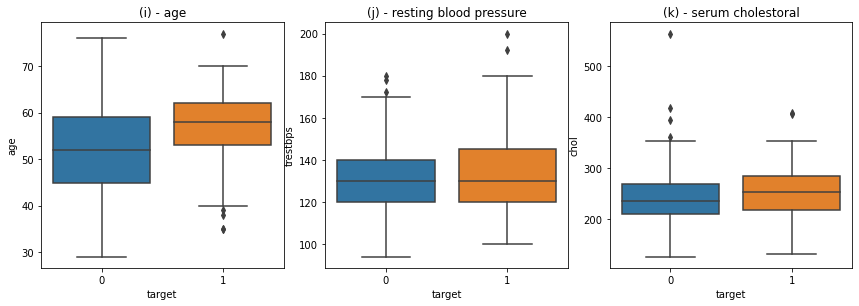

In [15]:
fig,ax = plt.subplots(1,3,figsize=(12,4))
fig.tight_layout()
sns.boxplot(x='target',y='age',data=heart,ax=ax[0])
sns.boxplot(x='target',y='trestbps',data=heart,ax=ax[1])
sns.boxplot(x='target',y='chol',data=heart,ax=ax[2])
ax[0].set_title('(i) - age')
ax[1].set_title('(j) - resting blood pressure')
ax[2].set_title('(k) - serum cholestoral')

#### (l) - The statistical difference between two groups is obvious. The patients with lower maximum heart rate are vulnerable to have a heart disease.

#### (m) - It is evident that the patients with higher ST depression induced by exercise relative to rest are more likely to have a heart disease.

Text(0.5, 1.0, '(m) - ST depression')

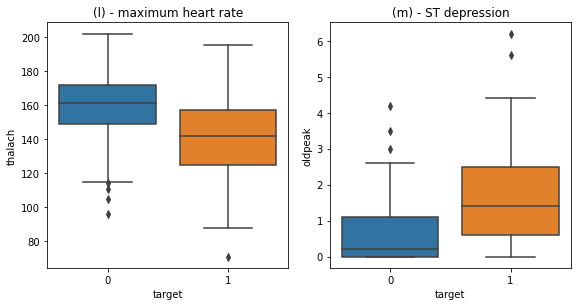

In [16]:
fig,ax = plt.subplots(1,2,figsize=(8,4))
fig.tight_layout()
sns.boxplot(x='target',y='thalach',data=heart,ax=ax[0])
sns.boxplot(x='target',y='oldpeak',data=heart,ax=ax[1])
ax[0].set_title('(l) - maximum heart rate')
ax[1].set_title('(m) - ST depression')

## Data Pre-processing

### Before we input the data into the models, we have to do some data manipulation so that it can fulfill the requirements by the models. Moreover, it may also help to achieve better prediction results. 

In [17]:
heart.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,1,145,233,1,2,150,0,2.3,3,0,6,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3,3,1
2,67,1,4,120,229,0,2,129,1,2.6,2,2,7,1
3,37,1,3,130,250,0,0,187,0,3.5,3,0,3,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0,3,0


### We will do one-hot encoding on the categorical features to prepare the input for some supervised learning models. This is important especially for the features that are not ordinal in essence. 

In [18]:
heart_ohe = pd.get_dummies(heart)
heart_ohe.head()

,age,trestbps,chol,thalach,oldpeak,target,sex_0,sex_1,cp_1,cp_2,...,slope_1,slope_2,slope_3,ca_0,ca_1,ca_2,ca_3,thal_3,thal_6,thal_7
0,63,145,233,150,2.3,0,0,1,1,0,...,0,0,1,1,0,0,0,0,1,0
1,67,160,286,108,1.5,1,0,1,0,0,...,0,1,0,0,0,0,1,1,0,0
2,67,120,229,129,2.6,1,0,1,0,0,...,0,1,0,0,0,1,0,0,0,1
3,37,130,250,187,3.5,0,0,1,0,0,...,0,0,1,1,0,0,0,1,0,0
4,41,130,204,172,1.4,0,1,0,0,1,...,1,0,0,1,0,0,0,1,0,0


### We notice that the scale of two features may vary greatly. Hence, we apply scaling on the non-one-hot-encoded features so that they are much comparable. This is necessary for the models that involve distance calculation.

In [19]:
scaler = StandardScaler()
heart_scaled = heart_ohe.copy()
cols = ['age','trestbps','chol','thalach','oldpeak']
heart_scaled[cols] = scaler.fit_transform(heart_scaled[cols])
heart_scaled.head()

,age,trestbps,chol,thalach,oldpeak,target,sex_0,sex_1,cp_1,cp_2,...,slope_1,slope_2,slope_3,ca_0,ca_1,ca_2,ca_3,thal_3,thal_6,thal_7
0,0.936181,0.750380,-0.276443,0.017494,1.068965,0,0,1,1,0,...,0,0,1,1,0,0,0,0,1,0
1,1.378929,1.596266,0.744555,-1.816334,0.381773,1,0,1,0,0,...,0,1,0,0,0,0,1,1,0,0
2,1.378929,-0.659431,-0.353500,-0.899420,1.326662,1,0,1,0,0,...,0,1,0,0,0,1,0,0,0,1
3,-1.941680,-0.095506,0.051047,1.633010,2.099753,0,0,1,0,0,...,0,0,1,1,0,0,0,1,0,0
4,-1.498933,-0.095506,-0.835103,0.978071,0.295874,0,1,0,0,1,...,1,0,0,1,0,0,0,1,0,0


## Class Prediction

### We are going to build three supervised learning models, namely, logistic regression, random forest, and neural network, to fit our dataset and then get the prediction for presence of heart disease. 

### We will use cross validation (K=5) for overfitting prevention and model selection. However, we notice that the number of samples over output classes varies a bit. So instead of ordinary KFold, we will use stratifiedKFold so that each class will appear in training data and test data as proportional to its population.  

### F1 score will be used as the key metric to evaluate the overall prediction performance in this project.

>## Logistic Regression

### We use one-hot encoded dataset as the input for logistic regression model. We fit the training data in each round of cross validation and predict the test data using the trained model. The average F1 score of logistic regression model on the test data is 0.869 and 0.835 for class 0 and 1 respectively.

In [20]:
X_col = list(heart_ohe.columns)
X_col.remove('target')
X = heart_ohe[X_col]
y = heart_ohe['target']

In [21]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
f1_lr=[]
for idx, (train_index, test_index) in enumerate(kf.split(X,y)):
    print("CV({}/{})".format(idx+1,kf.get_n_splits(X,y)))
    
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    lr = LogisticRegression(random_state=1)
    lr.fit(X_train, y_train)
    
    y_train_pred = lr.predict(X_train)
    y_test_pred = lr.predict(X_test)
    
    f1_train = f1_score(y_train,y_train_pred,average=None)
    f1_test = f1_score(y_test,y_test_pred,average=None)
    
    f1_lr.append(f1_test)
    
    print('Train F1 score:\t\t',['%.3f'%x for x in f1_train])
    print('Test  F1 score:\t\t',['%.3f'%x for x in f1_test])
    
print("*"*45)
print('Avg Test F1 score:\t',['%.3f'%x for x in np.mean(f1_lr,0)])

CV(1/5)
Train F1 score:		 ['0.891', '0.861']
Test  F1 score:		 ['0.862', '0.836']
CV(2/5)
Train F1 score:		 ['0.891', '0.861']
Test  F1 score:		 ['0.879', '0.852']
CV(3/5)
Train F1 score:		 ['0.892', '0.870']
Test  F1 score:		 ['0.849', '0.756']
CV(4/5)
Train F1 score:		 ['0.878', '0.850']
Test  F1 score:		 ['0.909', '0.885']
CV(5/5)
Train F1 score:		 ['0.876', '0.842']
Test  F1 score:		 ['0.847', '0.847']
*********************************************
Avg Test F1 score:	 ['0.869', '0.835']


### Now we would like to explore the ways of improvement to the logistic regression model we generated. The main objective is to enhance the F1 score for class 1. We will try assigning weight to the samples based on the output class and see how much the prediction performance could be improved. 

### Specifically, we generate a series of weight ranging from 0.01 to 0.99 with step=0.01. For each weight partition $(W_0,W_1)=(x,1-x)$ where $x$=0.01,0.02,...,0.99, we fit the model using training data, and calculate the average F1 score on test data. We will repeat this procedure for roughly 100 times. 

In [22]:
print(len(np.arange(0.01,1.0,0.01)),"iterations")
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
class_weight = []
for w0 in np.arange(0.01,1.0,0.01):
    print('.', end="")
    f1_lr2=[]
    for idx, (train_index, test_index) in enumerate(kf.split(X,y)):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        lr = LogisticRegression(class_weight={0:w0,1:1-w0},random_state=1)
        lr.fit(X_train, y_train)

        y_test_pred = lr.predict(X_test)

        f1_test = f1_score(y_test,y_test_pred,average=None)

        f1_lr2.append(f1_test)
    class_weight.append(np.hstack((w0,1-w0,np.mean(f1_lr2,0))))
print('|',end="")

99 iterations
...................................................................................................|

### We plot a line chart for F1 score against $W_0$. We can see the F1 score for class 0 ($F1_0$) is high when $W_0$ is between 0.4 and 0.7. The F1 score for class 1 ($F1_1$) is high when $W_0$ is between 0.3 and 0.5. However, the fluctuating behaviour in F1 score makes us difficult to identify the optimal $W_0$.

### To deal with the fluctuation, we calculate the rolling average for F1 score with a window size =9 and triangle window type (triangle weight assignment) to smoothen the curve. In the smoothened line chart, we can see $F1_0$ reaches maximum at $W_0\approx0.52$. However, at this point, $F1_1$ is not the highest (because of less weight for the samples of class 1). If we wish to get maximal $F1_1$, we have to choose $W_0\approx0.38$. The cost of doing this would be loss of accuracy in prediction of class 0. If we seek for a balance in both F1 scores, we may consider setting  $W_0$ to be a value near 0.5.

In [23]:
class_weight = pd.DataFrame(class_weight, columns=['W0','W1','F1_0','F1_1'])
class_weight['F1_0_rolling_avg'] = class_weight.rolling(9, center=True, min_periods=1, win_type='triang').mean().F1_0
class_weight['F1_1_rolling_avg'] = class_weight.rolling(9, center=True, min_periods=1, win_type='triang').mean().F1_1

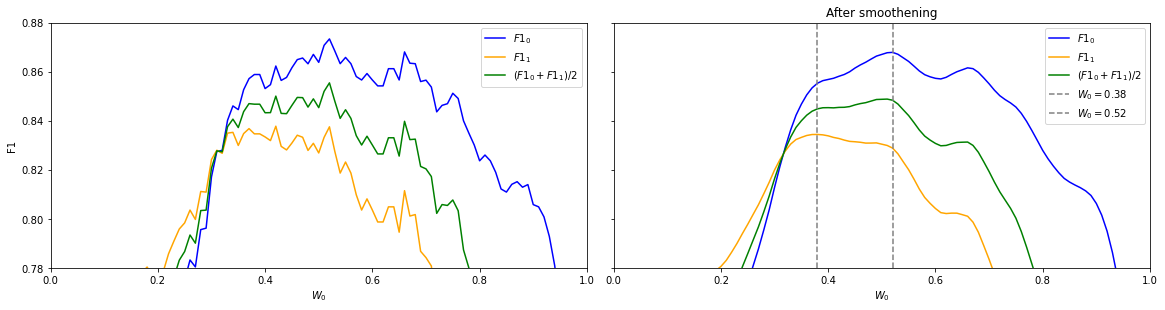

In [24]:
fig,ax = plt.subplots(1,2,figsize=(16,4),sharey=True)
fig.tight_layout()

sns.lineplot(x='W0',y='F1_0',data=class_weight,ax=ax[0], color='blue',label='$F1_0$')
sns.lineplot(x='W0',y='F1_1',data=class_weight,ax=ax[0], color='orange',label='$F1_1$')
sns.lineplot(x='W0',y=(class_weight.F1_0+class_weight.F1_1)/2,data=class_weight,ax=ax[0], color='green',label='$(F1_0+F1_1)/2$')
ax[0].set_xlim(0,1)
ax[0].set_ylim(0.78,0.88)
ax[0].set_xlabel('$W_0$')
ax[0].set_ylabel('F1')
ax[0].legend()

sns.lineplot(x='W0',y='F1_0_rolling_avg',data=class_weight,ax=ax[1], color='blue',label='$F1_0$')
sns.lineplot(x='W0',y='F1_1_rolling_avg',data=class_weight,ax=ax[1], color='orange',label='$F1_1$')
sns.lineplot(x='W0',y=(class_weight.F1_0_rolling_avg+class_weight.F1_1_rolling_avg)/2,data=class_weight,ax=ax[1], color='green',label='$(F1_0+F1_1)/2$')
ax[1].set_xlim(0,1)
ax[1].set_title('After smoothening')
ax[1].set_xlabel('$W_0$')
ax[1].set_ylabel('F1')
ax[1].axvline(0.38, ls='--',color='gray',label='$W_0=0.38$')
ax[1].axvline(0.52, ls='--',color='gray',label='$W_0=0.52$')
ax[1].legend()

>## Random Forest

### We use the original dataset as the input for random forest model by the nature of partitioning in decision tree model. Firstly, we use cross validation and fit the training data without tuning any hyper-parameters. The average F1 score on the test data is found to be 0.861 and 0.824 for two classes, which is slightly lower than that of logistic regression model. 

### It is worth mentioning that the train F1 score is 1. This is a sign of overfitting as the model is able to predict all the training data correctly. The reason behind this is probably the relatively small number of samples compared with large default max_depth(=10) in random forest model. In the next section, we are going to tune the hyper-parameters and see how much improvement we can achieve. 

In [25]:
X_col = list(heart.columns)
X_col.remove('target')
X = heart[X_col]
y = heart['target']

In [26]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
f1_rf=[]
for idx, (train_index, test_index) in enumerate(kf.split(X,y)):
    print("CV({}/{})".format(idx+1,kf.get_n_splits(X,y)))
    
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    rf = RandomForestClassifier(random_state=1)
    rf.fit(X_train, y_train)

    y_train_pred = rf.predict(X_train)
    y_test_pred = rf.predict(X_test)
    
    f1_train = f1_score(y_train,y_train_pred,average=None)
    f1_test = f1_score(y_test,y_test_pred,average=None)
    
    f1_rf.append(f1_test)
    
    print('Train F1 score:\t\t',['%.3f'%x for x in f1_train])
    print('Test  F1 score:\t\t',['%.3f'%x for x in f1_test])
    
print("*"*45)
print('Avg Test F1 score:\t',['%.3f'%x for x in np.mean(f1_rf,0)])

CV(1/5)
Train F1 score:		 ['1.000', '1.000']
Test  F1 score:		 ['0.857', '0.842']
CV(2/5)
Train F1 score:		 ['1.000', '1.000']
Test  F1 score:		 ['0.848', '0.815']
CV(3/5)
Train F1 score:		 ['1.000', '1.000']
Test  F1 score:		 ['0.806', '0.696']
CV(4/5)
Train F1 score:		 ['1.000', '1.000']
Test  F1 score:		 ['0.889', '0.873']
CV(5/5)
Train F1 score:		 ['1.000', '1.000']
Test  F1 score:		 ['0.903', '0.893']
*********************************************
Avg Test F1 score:	 ['0.861', '0.824']


### We would like to know how the prediction performance for training data and test data would change as the value of hyper-parameters changes. For simplicity, we will still use F1 score as the metric in the following steps of hyper-parameter tuning. 

### The random forest model provides us with a variety of hyper-parameters to be tuned but we will restrict ourselves to only 2 hyper-parameters in this project, namely, min_impurity_decrease and n_estimators. This is because the hyper-parameter 'min_impurity_decrease' is essentially controlling the complexity of a decision tree (stopping spliting if gain is low). It is doing a similar job as 'max_depth', 'min_samples_split', 'max_leaf_nodes', 'min_samples_leaf', etc. 'n_estimators' is simply the number of decision trees used in the random forest model. A larger $n$ guarantees a more reliable result.

### In practice, we start with a random forest model with loose constraints by modifying the value of hyper-parameters. For example, we know that the default value of 'max_depth' is 10. But if we change this hyper-parameter to 100, it is equivalent to make the random forest model have no constraint in the depth of decision trees. The rest of hyper-parameters are modified by the same principle.

### For the two hyper-parameters selected, we will pick one value each from the given list consisting of a bunch of possible values. Then, we will calculate the F1 score on the test data for the model based on the hyper-parameter combination. We repeat this procedure for many times to get every possible combination.

In [27]:
def RandomForestTuning(p1,p2):
    print(len(np.arange(*p1))*len(np.arange(*p2)),"iterations")
    clf = RandomForestClassifier(max_depth=100,min_samples_split=2,max_leaf_nodes=500,min_samples_leaf=1,random_state=1)
    out = []
    
    for i in np.arange(*p1):
        for j in np.arange(*p2):
            print('.', end="")
            
            min_impurity_decrease_val = pow(10,-i)
            n_estimators_val = j.astype(int)
    
            clf.set_params(min_impurity_decrease=min_impurity_decrease_val,n_estimators=n_estimators_val)

            kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
            f1_clf_train=[]
            f1_clf_test=[]
            for idx, (train_index, test_index) in enumerate(kf.split(X,y)):
                X_train, X_test = X.iloc[train_index], X.iloc[test_index]
                y_train, y_test = y.iloc[train_index], y.iloc[test_index]

                clf.fit(X_train, y_train)

                y_train_pred = clf.predict(X_train)
                y_test_pred = clf.predict(X_test)

                f1_train = f1_score(y_train,y_train_pred,average=None)
                f1_test = f1_score(y_test,y_test_pred,average=None)

                f1_clf_train.append(f1_train)
                f1_clf_test.append(f1_test)

            params = [-np.log10(min_impurity_decrease_val),n_estimators_val]
            out.append(np.hstack((params, np.mean(f1_clf_train,0), np.mean(f1_clf_test,0))))\
            
    return out

    
rfs = RandomForestTuning((0.5,10,1.5),(5,100,15))
rfs = pd.DataFrame(rfs,columns=['min_impurity_decrease','n_estimators','F1_train_0','F1_train_1','F1_test_0','F1_test_1'])
print('|',end="")

49 iterations
.................................................|

In [28]:
rfs.sample(10,random_state=1)

,min_impurity_decrease,n_estimators,F1_train_0,F1_train_1,F1_test_0,F1_test_1
27,5.0,95.0,1.000000,1.000000,0.878925,0.847170
34,6.5,95.0,1.000000,1.000000,0.878925,0.847170
39,8.0,65.0,1.000000,1.000000,0.858229,0.819529
48,9.5,95.0,1.000000,1.000000,0.878925,0.847170
2,0.5,35.0,0.700220,0.000000,0.700239,0.000000
3,0.5,50.0,0.700220,0.000000,0.700239,0.000000
42,9.5,5.0,0.974324,0.969751,0.814504,0.782941
29,6.5,20.0,0.996109,0.995425,0.846275,0.803631
45,9.5,50.0,1.000000,1.000000,0.865073,0.825829
30,6.5,35.0,0.999216,0.999095,0.855625,0.814249


### Next, we will sort the experimental results based on the average of  test F1 score for two classes. After sorting, we will calculate the cumulative average for each of the two hyper-parameters as well as the train F1 score for two classes. For 'min_impurity_decrease', we will average the exponent instead. We do this calculation twice for the data sorted by ascending and descending average F1 score respectively. Then, we would be able to see how the variation of hyper-parameters can affect the prediction performance in general. 

In [29]:
rfs2 = rfs.copy()

rfs2['rank_desc']=(rfs2.F1_test_0 + rfs2.F1_test_1).rank(ascending=False, method='first')
rfs_cum_avg_desc = rfs2.sort_values(by='rank_desc').expanding().mean().iloc[:,0:4]
rfs_cum_avg_desc.rename(lambda x: x+'_cum_avg_desc', axis=1, inplace=True)
rfs2 = pd.concat([rfs2.sort_values(by='rank_desc'), rfs_cum_avg_desc], axis=1)

rfs2['rank_asc']=(rfs2.F1_test_0 + rfs2.F1_test_1).rank(method='first')
rfs_cum_avg_asc = rfs2.sort_values(by='rank_asc').expanding().mean().iloc[:,0:4]
rfs_cum_avg_asc.rename(lambda x: x+'_cum_avg_asc', axis=1, inplace=True)
rfs2 = pd.concat([rfs2.sort_values(by='rank_asc'), rfs_cum_avg_asc], axis=1)

### The orange curve in each of the line charts below represents the hyper-parameter value for the $N$ best models (descending F1 score) while the blue curves belong to the $N$ worst models (ascending F1 score). 

#### (a) - A good model favours small 'min_impurity_decrease' (typically $10^{-7}$ to $10^{-6}$). This value is almost negligible so we expect the numbef of samples in a leaf is quite small.
#### (b) - A good model favours large 'n_estimators'. We can see that there is little fluctuation in the orange curve. So we have much confidence to say that more decision trees we have, more accurate our prediction would be.

Text(0.5, 1.0, '(b) - cum avg of n_estimators \nfor N highest/lowest test F1 score')

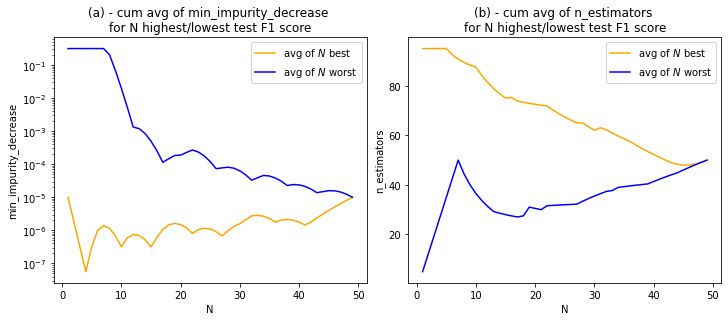

In [30]:
fig,ax = plt.subplots(1,2,figsize=(10,4))
fig.tight_layout()

sns.lineplot(x='rank_desc',y=10**(-rfs2.min_impurity_decrease_cum_avg_desc),data=rfs2,ax=ax[0],color='orange',label='avg of $N$ best')
sns.lineplot(x='rank_asc',y=10**(-rfs2.min_impurity_decrease_cum_avg_asc),data=rfs2,ax=ax[0],color='blue',label='avg of $N$ worst')
ax[0].set_yscale('log')
ax[0].set_xlabel('N')
ax[0].set_ylabel('min_impurity_decrease')
ax[0].set_title('(a) - cum avg of min_impurity_decrease \nfor N highest/lowest test F1 score')

sns.lineplot(x='rank_desc',y='n_estimators_cum_avg_desc',data=rfs2,ax=ax[1],color='orange',label='avg of $N$ best')
sns.lineplot(x='rank_asc',y='n_estimators_cum_avg_asc',data=rfs2,ax=ax[1],color='blue',label='avg of $N$ worst')
ax[1].set_xlabel('N')
ax[1].set_ylabel('n_estimators')
ax[1].set_title('(b) - cum avg of n_estimators \nfor N highest/lowest test F1 score')

#### From the two plots below, it is quite clear that the model can fit perfectly on the training data. However, as we try generalizing the model by tuning the hyper-parameters, the prediction on the test data does not improve. Therefore, we doubt the decision tree based model might be suitable for the dataset given.



Text(0.5, 1.0, '(d) - cum avg of F1_train_1 \nfor N highest/lowest F1 score')

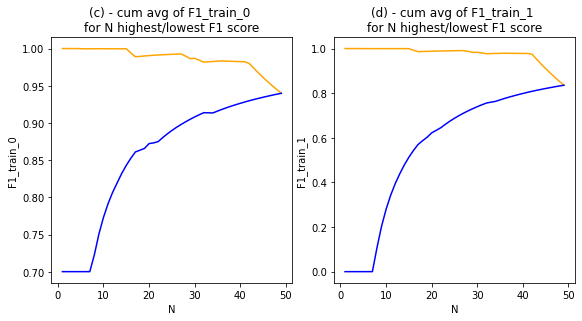

In [31]:
fig,ax = plt.subplots(1,2,figsize=(8,4))
fig.tight_layout()

sns.lineplot(x='rank_desc',y='F1_train_0_cum_avg_desc',data=rfs2,ax=ax[0],color='orange')
sns.lineplot(x='rank_asc',y='F1_train_0_cum_avg_asc',data=rfs2,ax=ax[0],color='blue')
ax[0].set_xlabel('N')
ax[0].set_ylabel('F1_train_0')
ax[0].set_title('(c) - cum avg of F1_train_0 \nfor N highest/lowest F1 score')

sns.lineplot(x='rank_desc',y='F1_train_1_cum_avg_desc',data=rfs2,ax=ax[1],color='orange')
sns.lineplot(x='rank_asc',y='F1_train_1_cum_avg_asc',data=rfs2,ax=ax[1],color='blue')
ax[1].set_xlabel('N')
ax[1].set_ylabel('F1_train_1')
ax[1].set_title('(d) - cum avg of F1_train_1 \nfor N highest/lowest F1 score')

>## Neural Network

### We use one-hot encoded dataset as the input for neural network model. In each round of cross validation, we will use the neural network model of identical structure. The input layer takes in 28 features from each sample and output to 32 nodes in the first hidden layer. We add another 2 hidden layers with 64 and 128 nodes respectively to increase complexity of the network. The output layer has only one node to give the probability.

### We use 'relu' as the activation function in the hiddle layers and 'sigmoid' in the output layer, for a binary classification neural network. In terms of weight initialization, we use 'uniform' for kernel and 'zeros' for bias by convention. We choose 'binary_crossentropy' as the loss function, 'adam' as the optimizer, and 'accuracy' as the metric for the model. 

### During model fitting, we use a batch size =32. The 'epochs' we choose is 100 to guarantee the learning has stablized. In addition, we will also use 'validation_split'=0.2 to split the training data into a portion of validation data. As what we did for the previous models, we will calculate F1 score for training data and test data respectively based on the model generated. The average F1 score is quite close to the result obtained early.

In [32]:
X_col = list(heart_ohe.columns)
X_col.remove('target')
X = heart_ohe[X_col]
y = heart_ohe['target']

In [33]:
set_seed(1)
np.random.seed(1)

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
f1_nn_train=[]
f1_nn_test=[]
historys=[]

for idx, (train_index, test_index) in enumerate(kf.split(X,y)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    nn = Sequential()
    nn.add(Dense(units=32, input_dim=X_train.shape[1], activation='relu', kernel_initializer='uniform',bias_initializer='zeros'))
    nn.add(Dense(units=64, activation='relu', kernel_initializer='uniform',bias_initializer='zeros'))
    nn.add(Dense(units=128, activation='relu', kernel_initializer='uniform',bias_initializer='zeros'))
    nn.add(Dense(units=1, activation='sigmoid', kernel_initializer='uniform',bias_initializer='zeros'))
    nn.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

    history = nn.fit(X_train,y_train,validation_data=(X_test, y_test),epochs=100,batch_size=32,validation_split=0.2)
    history_df = pd.DataFrame(history.history)
    history_df['epoch'] = history.epoch
    history_df['cv'] = idx+1
    historys.append(history_df)

    y_train_pred = np.round(nn.predict(X_train))
    y_test_pred = np.round(nn.predict(X_test))

    f1_train = f1_score(y_train,y_train_pred,average=None)
    f1_test = f1_score(y_test,y_test_pred,average=None)

    f1_nn_train.append(f1_train)
    f1_nn_test.append(f1_test)

Epoch 1/100
6/6 [==============================] - 0s 22ms/step - loss: 0.6870 - accuracy: 0.5608 - val_loss: 0.6999 - val_accuracy: 0.4583
Epoch 2/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6784 - accuracy: 0.5608 - val_loss: 0.7072 - val_accuracy: 0.4583
Epoch 3/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6705 - accuracy: 0.5608 - val_loss: 0.6932 - val_accuracy: 0.4792
Epoch 4/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6639 - accuracy: 0.6455 - val_loss: 0.6878 - val_accuracy: 0.4792
Epoch 5/100
6/6 [==============================] - 0s 5ms/step - loss: 0.6448 - accuracy: 0.6138 - val_loss: 0.6882 - val_accuracy: 0.5417
Epoch 6/100
6/6 [==============================] - 0s 4ms/step - loss: 0.6268 - accuracy: 0.6402 - val_loss: 0.6560 - val_accuracy: 0.5833
Epoch 7/100
6/6 [==============================] - 0s 4ms/step - loss: 0.6087 - accuracy: 0.6984 - val_loss: 0.6575 - val_accuracy: 0.5625
Epoch 8/100
6/6 [=========

6/6 [==============================] - 0s 3ms/step - loss: 0.2948 - accuracy: 0.8730 - val_loss: 0.4978 - val_accuracy: 0.8333
Epoch 60/100
6/6 [==============================] - 0s 3ms/step - loss: 0.3011 - accuracy: 0.8783 - val_loss: 0.4653 - val_accuracy: 0.8125
Epoch 61/100
6/6 [==============================] - 0s 3ms/step - loss: 0.3101 - accuracy: 0.8624 - val_loss: 0.5174 - val_accuracy: 0.8125
Epoch 62/100
6/6 [==============================] - 0s 3ms/step - loss: 0.3137 - accuracy: 0.8624 - val_loss: 0.5452 - val_accuracy: 0.8125
Epoch 63/100
6/6 [==============================] - 0s 3ms/step - loss: 0.3313 - accuracy: 0.8624 - val_loss: 0.4479 - val_accuracy: 0.8125
Epoch 64/100
6/6 [==============================] - 0s 3ms/step - loss: 0.3298 - accuracy: 0.8677 - val_loss: 0.6728 - val_accuracy: 0.6667
Epoch 65/100
6/6 [==============================] - 0s 3ms/step - loss: 0.3709 - accuracy: 0.8360 - val_loss: 0.4674 - val_accuracy: 0.7708
Epoch 66/100
6/6 [===============

6/6 [==============================] - 0s 3ms/step - loss: 0.4646 - accuracy: 0.7566 - val_loss: 0.5529 - val_accuracy: 0.7083
Epoch 18/100
6/6 [==============================] - 0s 4ms/step - loss: 0.4710 - accuracy: 0.7884 - val_loss: 0.5005 - val_accuracy: 0.7917
Epoch 19/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4601 - accuracy: 0.7725 - val_loss: 0.5629 - val_accuracy: 0.7083
Epoch 20/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4776 - accuracy: 0.7725 - val_loss: 0.4917 - val_accuracy: 0.7917
Epoch 21/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4477 - accuracy: 0.7619 - val_loss: 0.5073 - val_accuracy: 0.7500
Epoch 22/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4372 - accuracy: 0.7884 - val_loss: 0.5090 - val_accuracy: 0.7500
Epoch 23/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4263 - accuracy: 0.8148 - val_loss: 0.4811 - val_accuracy: 0.7917
Epoch 24/100
6/6 [===============

6/6 [==============================] - 0s 3ms/step - loss: 0.2999 - accuracy: 0.8942 - val_loss: 0.4357 - val_accuracy: 0.7917
Epoch 76/100
6/6 [==============================] - 0s 3ms/step - loss: 0.2824 - accuracy: 0.8942 - val_loss: 0.5662 - val_accuracy: 0.7500
Epoch 77/100
6/6 [==============================] - 0s 3ms/step - loss: 0.3109 - accuracy: 0.8730 - val_loss: 0.3815 - val_accuracy: 0.8125
Epoch 78/100
6/6 [==============================] - 0s 3ms/step - loss: 0.3341 - accuracy: 0.8677 - val_loss: 0.4586 - val_accuracy: 0.7917
Epoch 79/100
6/6 [==============================] - 0s 3ms/step - loss: 0.3080 - accuracy: 0.8730 - val_loss: 0.4992 - val_accuracy: 0.7708
Epoch 80/100
6/6 [==============================] - 0s 3ms/step - loss: 0.2836 - accuracy: 0.8942 - val_loss: 0.3857 - val_accuracy: 0.8125
Epoch 81/100
6/6 [==============================] - 0s 3ms/step - loss: 0.3235 - accuracy: 0.8677 - val_loss: 0.5322 - val_accuracy: 0.7500
Epoch 82/100
6/6 [===============

6/6 [==============================] - 0s 3ms/step - loss: 0.3812 - accuracy: 0.8421 - val_loss: 0.4963 - val_accuracy: 0.7292
Epoch 34/100
6/6 [==============================] - 0s 3ms/step - loss: 0.3695 - accuracy: 0.8316 - val_loss: 0.4839 - val_accuracy: 0.7500
Epoch 35/100
6/6 [==============================] - 0s 4ms/step - loss: 0.3601 - accuracy: 0.8316 - val_loss: 0.4671 - val_accuracy: 0.7917
Epoch 36/100
6/6 [==============================] - 0s 3ms/step - loss: 0.3716 - accuracy: 0.8316 - val_loss: 0.5747 - val_accuracy: 0.7292
Epoch 37/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4324 - accuracy: 0.8000 - val_loss: 0.5064 - val_accuracy: 0.7500
Epoch 38/100
6/6 [==============================] - 0s 3ms/step - loss: 0.3786 - accuracy: 0.8105 - val_loss: 0.4383 - val_accuracy: 0.8333
Epoch 39/100
6/6 [==============================] - 0s 3ms/step - loss: 0.3576 - accuracy: 0.8263 - val_loss: 0.4910 - val_accuracy: 0.7500
Epoch 40/100
6/6 [===============

6/6 [==============================] - 0s 3ms/step - loss: 0.3046 - accuracy: 0.8789 - val_loss: 0.3953 - val_accuracy: 0.8542
Epoch 92/100
6/6 [==============================] - 0s 3ms/step - loss: 0.3175 - accuracy: 0.8579 - val_loss: 0.5463 - val_accuracy: 0.7708
Epoch 93/100
6/6 [==============================] - 0s 3ms/step - loss: 0.3158 - accuracy: 0.8684 - val_loss: 0.3876 - val_accuracy: 0.8333
Epoch 94/100
6/6 [==============================] - 0s 3ms/step - loss: 0.2922 - accuracy: 0.8947 - val_loss: 0.3889 - val_accuracy: 0.8333
Epoch 95/100
6/6 [==============================] - 0s 3ms/step - loss: 0.2756 - accuracy: 0.8895 - val_loss: 0.4261 - val_accuracy: 0.8333
Epoch 96/100
6/6 [==============================] - 0s 3ms/step - loss: 0.2874 - accuracy: 0.9053 - val_loss: 0.4520 - val_accuracy: 0.8333
Epoch 97/100
6/6 [==============================] - 0s 3ms/step - loss: 0.3239 - accuracy: 0.8684 - val_loss: 0.3979 - val_accuracy: 0.8542
Epoch 98/100
6/6 [===============

6/6 [==============================] - 0s 3ms/step - loss: 0.3224 - accuracy: 0.8895 - val_loss: 0.5578 - val_accuracy: 0.7917
Epoch 50/100
6/6 [==============================] - 0s 3ms/step - loss: 0.3217 - accuracy: 0.8579 - val_loss: 0.7454 - val_accuracy: 0.6667
Epoch 51/100
6/6 [==============================] - 0s 3ms/step - loss: 0.3493 - accuracy: 0.8526 - val_loss: 0.5334 - val_accuracy: 0.7917
Epoch 52/100
6/6 [==============================] - 0s 3ms/step - loss: 0.3107 - accuracy: 0.8842 - val_loss: 0.5467 - val_accuracy: 0.7917
Epoch 53/100
6/6 [==============================] - 0s 3ms/step - loss: 0.3152 - accuracy: 0.8579 - val_loss: 0.7878 - val_accuracy: 0.6875
Epoch 54/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4304 - accuracy: 0.8053 - val_loss: 0.5170 - val_accuracy: 0.7917
Epoch 55/100
6/6 [==============================] - 0s 4ms/step - loss: 0.3227 - accuracy: 0.8632 - val_loss: 0.5781 - val_accuracy: 0.7083
Epoch 56/100
6/6 [===============

6/6 [==============================] - 0s 3ms/step - loss: 0.5949 - accuracy: 0.7053 - val_loss: 0.6911 - val_accuracy: 0.5625
Epoch 8/100
6/6 [==============================] - 0s 3ms/step - loss: 0.5762 - accuracy: 0.6842 - val_loss: 0.6430 - val_accuracy: 0.6250
Epoch 9/100
6/6 [==============================] - 0s 3ms/step - loss: 0.5386 - accuracy: 0.7421 - val_loss: 0.7270 - val_accuracy: 0.5417
Epoch 10/100
6/6 [==============================] - 0s 3ms/step - loss: 0.5524 - accuracy: 0.7211 - val_loss: 0.6323 - val_accuracy: 0.6667
Epoch 11/100
6/6 [==============================] - 0s 3ms/step - loss: 0.5171 - accuracy: 0.7421 - val_loss: 0.7521 - val_accuracy: 0.5417
Epoch 12/100
6/6 [==============================] - 0s 3ms/step - loss: 0.5333 - accuracy: 0.7316 - val_loss: 0.6262 - val_accuracy: 0.6875
Epoch 13/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4886 - accuracy: 0.7737 - val_loss: 0.6859 - val_accuracy: 0.6042
Epoch 14/100
6/6 [=================

6/6 [==============================] - 0s 3ms/step - loss: 0.3148 - accuracy: 0.8632 - val_loss: 0.4825 - val_accuracy: 0.8125
Epoch 66/100
6/6 [==============================] - 0s 3ms/step - loss: 0.2904 - accuracy: 0.8737 - val_loss: 0.5734 - val_accuracy: 0.7292
Epoch 67/100
6/6 [==============================] - 0s 3ms/step - loss: 0.3013 - accuracy: 0.8684 - val_loss: 0.5434 - val_accuracy: 0.7500
Epoch 68/100
6/6 [==============================] - 0s 3ms/step - loss: 0.2896 - accuracy: 0.8789 - val_loss: 0.5143 - val_accuracy: 0.7500
Epoch 69/100
6/6 [==============================] - 0s 3ms/step - loss: 0.2784 - accuracy: 0.8737 - val_loss: 0.5815 - val_accuracy: 0.7083
Epoch 70/100
6/6 [==============================] - 0s 3ms/step - loss: 0.3008 - accuracy: 0.8684 - val_loss: 0.4914 - val_accuracy: 0.8125
Epoch 71/100
6/6 [==============================] - 0s 3ms/step - loss: 0.2830 - accuracy: 0.8842 - val_loss: 0.5005 - val_accuracy: 0.7917
Epoch 72/100
6/6 [===============

In [34]:
for idx in range(kf.n_splits):
    print("CV({}/{})".format(idx+1,kf.get_n_splits(X,y)))
    print('Train F1 score:\t\t',['%.3f'%x for x in f1_nn_train[idx]])
    print('Test  F1 score:\t\t',['%.3f'%x for x in f1_nn_test[idx]])
    
print("*"*45)
print('Avg Test F1 score:\t',['%.3f'%x for x in np.mean(f1_nn_test,0)])

CV(1/5)
Train F1 score:		 ['0.866', '0.800']
Test  F1 score:		 ['0.845', '0.776']
CV(2/5)
Train F1 score:		 ['0.896', '0.864']
Test  F1 score:		 ['0.853', '0.808']
CV(3/5)
Train F1 score:		 ['0.885', '0.850']
Test  F1 score:		 ['0.865', '0.773']
CV(4/5)
Train F1 score:		 ['0.875', '0.833']
Test  F1 score:		 ['0.896', '0.863']
CV(5/5)
Train F1 score:		 ['0.851', '0.837']
Test  F1 score:		 ['0.786', '0.806']
*********************************************
Avg Test F1 score:	 ['0.849', '0.805']


### From the diagrams below, we can see the train accuracy improves rapidly at the beginning of training and then flattens out when 'epoch' approaches 60. For the test accuracy, we can see a similar pattern but the fluctuation is heavier. 

Text(0.5, 1.0, 'Test accuracy vs. Epoch')

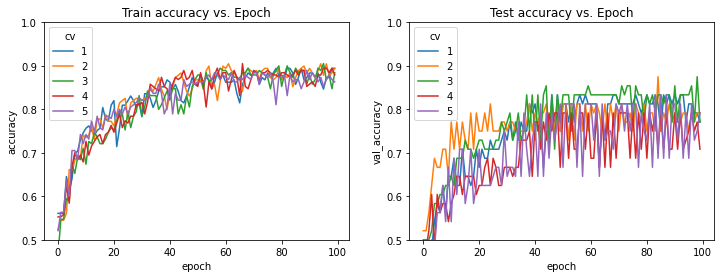

In [35]:
history_df = pd.concat(historys)
history_df['cv'] = history_df['cv'].astype('category')

fig,ax = plt.subplots(1,2,figsize=(12,4))
sns.lineplot(x='epoch',y='accuracy',hue='cv',data=history_df,ax=ax[0])
sns.lineplot(x='epoch',y='val_accuracy',hue='cv',data=history_df,ax=ax[1])
ax[0].set_ylim(0.5,1)
ax[1].set_ylim(0.5,1)
ax[0].set_title('Train accuracy vs. Epoch')
ax[1].set_title('Test accuracy vs. Epoch')

### To prevent overfitting, we sometimes use 'EarlyStopping' to configure a condition where the training could stop before reaching the maximal epochs. Here, we monitor 'val_loss' and set patience =10. From the results we obtained, we can see both F1 score has slightly improved after using an 'EarlyStopping' function.

In [36]:
early_stop = EarlyStopping(monitor = 'val_loss',patience = 10)

In [37]:
X_col = list(heart_ohe.columns)
X_col.remove('target')
X = heart_ohe[X_col]
y = heart_ohe['target']

In [38]:
set_seed(1)
np.random.seed(1)

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
f1_nn_es_train=[]
f1_nn_es_test=[]
historys_es=[]

for idx, (train_index, test_index) in enumerate(kf.split(X,y)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    nn = Sequential()
    nn.add(Dense(units=32, input_dim=X_train.shape[1], activation='relu', kernel_initializer='uniform',bias_initializer='zeros'))
    nn.add(Dense(units=64, activation='relu', kernel_initializer='uniform',bias_initializer='zeros'))
    nn.add(Dense(units=128, activation='relu', kernel_initializer='uniform',bias_initializer='zeros'))
    nn.add(Dense(units=1, activation='sigmoid', kernel_initializer='uniform',bias_initializer='zeros'))
    nn.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

    history = nn.fit(X_train,y_train,epochs=100,batch_size=32,validation_split=0.2,callbacks=early_stop)
    history_df = pd.DataFrame(history.history)
    history_df['epoch'] = history.epoch
    history_df['cv'] = idx+1
    historys_es.append(history_df)

    y_train_pred = np.round(nn.predict(X_train))
    y_test_pred = np.round(nn.predict(X_test))

    f1_train = f1_score(y_train,y_train_pred,average=None)
    f1_test = f1_score(y_test,y_test_pred,average=None)

    f1_nn_es_train.append(f1_train)
    f1_nn_es_test.append(f1_test)

Epoch 1/100
6/6 [==============================] - 0s 18ms/step - loss: 0.6870 - accuracy: 0.5608 - val_loss: 0.6999 - val_accuracy: 0.4583
Epoch 2/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6784 - accuracy: 0.5608 - val_loss: 0.7072 - val_accuracy: 0.4583
Epoch 3/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6705 - accuracy: 0.5608 - val_loss: 0.6932 - val_accuracy: 0.4792
Epoch 4/100
6/6 [==============================] - 0s 4ms/step - loss: 0.6639 - accuracy: 0.6455 - val_loss: 0.6878 - val_accuracy: 0.4792
Epoch 5/100
6/6 [==============================] - 0s 4ms/step - loss: 0.6448 - accuracy: 0.6138 - val_loss: 0.6882 - val_accuracy: 0.5417
Epoch 6/100
6/6 [==============================] - 0s 4ms/step - loss: 0.6268 - accuracy: 0.6402 - val_loss: 0.6560 - val_accuracy: 0.5833
Epoch 7/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6087 - accuracy: 0.6984 - val_loss: 0.6575 - val_accuracy: 0.5625
Epoch 8/100
6/6 [=========

6/6 [==============================] - 0s 3ms/step - loss: 0.2948 - accuracy: 0.8730 - val_loss: 0.4978 - val_accuracy: 0.8333
Epoch 1/100
6/6 [==============================] - 0s 17ms/step - loss: 0.6907 - accuracy: 0.5238 - val_loss: 0.6891 - val_accuracy: 0.5208
Epoch 2/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6824 - accuracy: 0.5450 - val_loss: 0.6843 - val_accuracy: 0.5208
Epoch 3/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6746 - accuracy: 0.5450 - val_loss: 0.6783 - val_accuracy: 0.5625
Epoch 4/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6632 - accuracy: 0.5608 - val_loss: 0.6694 - val_accuracy: 0.6250
Epoch 5/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6445 - accuracy: 0.6614 - val_loss: 0.6544 - val_accuracy: 0.6875
Epoch 6/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6233 - accuracy: 0.6614 - val_loss: 0.6402 - val_accuracy: 0.6667
Epoch 7/100
6/6 [=====================

Epoch 2/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6872 - accuracy: 0.5474 - val_loss: 0.6925 - val_accuracy: 0.5000
Epoch 3/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6812 - accuracy: 0.5474 - val_loss: 0.6926 - val_accuracy: 0.5000
Epoch 4/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6741 - accuracy: 0.5947 - val_loss: 0.6886 - val_accuracy: 0.5208
Epoch 5/100
6/6 [==============================] - 0s 4ms/step - loss: 0.6610 - accuracy: 0.5895 - val_loss: 0.6884 - val_accuracy: 0.5833
Epoch 6/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6438 - accuracy: 0.6737 - val_loss: 0.6752 - val_accuracy: 0.5833
Epoch 7/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6136 - accuracy: 0.6526 - val_loss: 0.7030 - val_accuracy: 0.6042
Epoch 8/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6016 - accuracy: 0.6895 - val_loss: 0.6616 - val_accuracy: 0.6042
Epoch 9/100
6/6 [==========

6/6 [==============================] - 0s 3ms/step - loss: 0.2915 - accuracy: 0.8895 - val_loss: 0.4134 - val_accuracy: 0.8542
Epoch 61/100
6/6 [==============================] - 0s 3ms/step - loss: 0.2874 - accuracy: 0.8895 - val_loss: 0.4817 - val_accuracy: 0.8333
Epoch 62/100
6/6 [==============================] - 0s 3ms/step - loss: 0.2988 - accuracy: 0.8789 - val_loss: 0.4158 - val_accuracy: 0.8333
Epoch 63/100
6/6 [==============================] - 0s 3ms/step - loss: 0.2863 - accuracy: 0.8842 - val_loss: 0.4406 - val_accuracy: 0.8333
Epoch 64/100
6/6 [==============================] - 0s 3ms/step - loss: 0.3063 - accuracy: 0.8737 - val_loss: 0.4440 - val_accuracy: 0.8333
Epoch 65/100
6/6 [==============================] - 0s 3ms/step - loss: 0.3321 - accuracy: 0.8737 - val_loss: 0.3998 - val_accuracy: 0.8333
Epoch 66/100
6/6 [==============================] - 0s 3ms/step - loss: 0.3160 - accuracy: 0.8684 - val_loss: 0.4142 - val_accuracy: 0.8333
Epoch 67/100
6/6 [===============

6/6 [==============================] - 0s 3ms/step - loss: 0.4257 - accuracy: 0.8105 - val_loss: 0.6144 - val_accuracy: 0.6250
Epoch 30/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4141 - accuracy: 0.8105 - val_loss: 0.6544 - val_accuracy: 0.6667
Epoch 31/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4092 - accuracy: 0.8158 - val_loss: 0.6002 - val_accuracy: 0.6667
Epoch 32/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4093 - accuracy: 0.7895 - val_loss: 0.6601 - val_accuracy: 0.6667
Epoch 33/100
6/6 [==============================] - 0s 3ms/step - loss: 0.3801 - accuracy: 0.8158 - val_loss: 0.5958 - val_accuracy: 0.6458
Epoch 34/100
6/6 [==============================] - 0s 3ms/step - loss: 0.3700 - accuracy: 0.8579 - val_loss: 0.6316 - val_accuracy: 0.6667
Epoch 35/100
6/6 [==============================] - 0s 3ms/step - loss: 0.3715 - accuracy: 0.8526 - val_loss: 0.6323 - val_accuracy: 0.6667
Epoch 36/100
6/6 [===============

6/6 [==============================] - 0s 3ms/step - loss: 0.5762 - accuracy: 0.6842 - val_loss: 0.6430 - val_accuracy: 0.6250
Epoch 9/100
6/6 [==============================] - 0s 3ms/step - loss: 0.5386 - accuracy: 0.7421 - val_loss: 0.7270 - val_accuracy: 0.5417
Epoch 10/100
6/6 [==============================] - 0s 3ms/step - loss: 0.5524 - accuracy: 0.7211 - val_loss: 0.6323 - val_accuracy: 0.6667
Epoch 11/100
6/6 [==============================] - 0s 3ms/step - loss: 0.5171 - accuracy: 0.7421 - val_loss: 0.7521 - val_accuracy: 0.5417
Epoch 12/100
6/6 [==============================] - 0s 3ms/step - loss: 0.5333 - accuracy: 0.7316 - val_loss: 0.6262 - val_accuracy: 0.6875
Epoch 13/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4886 - accuracy: 0.7737 - val_loss: 0.6859 - val_accuracy: 0.6042
Epoch 14/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4950 - accuracy: 0.7474 - val_loss: 0.6152 - val_accuracy: 0.7083
Epoch 15/100
6/6 [================

In [39]:
for idx in range(kf.n_splits):
    print("CV({}/{})".format(idx+1,kf.get_n_splits(X,y)))
    print('Train F1 score:\t\t',['%.3f'%x for x in f1_nn_es_train[idx]])
    print('Test  F1 score:\t\t',['%.3f'%x for x in f1_nn_es_test[idx]])
    
print("*"*45)
print('Avg Test F1 score:\t',['%.3f'%x for x in np.mean(f1_nn_es_test,0)])

CV(1/5)
Train F1 score:		 ['0.891', '0.860']
Test  F1 score:		 ['0.848', '0.815']
CV(2/5)
Train F1 score:		 ['0.862', '0.842']
Test  F1 score:		 ['0.879', '0.852']
CV(3/5)
Train F1 score:		 ['0.889', '0.865']
Test  F1 score:		 ['0.861', '0.783']
CV(4/5)
Train F1 score:		 ['0.875', '0.822']
Test  F1 score:		 ['0.870', '0.816']
CV(5/5)
Train F1 score:		 ['0.883', '0.853']
Test  F1 score:		 ['0.814', '0.814']
*********************************************
Avg Test F1 score:	 ['0.854', '0.816']


## Dimensionality Reduction $-$ Principal Component Analysis

### Sometimes we may wish to use fewer features to describe our dataset. However, it is inevitable that some information would be lost. The principal component analysis (PCA) provides us with a methodology of using fewer features to keep as much information as possible.

### In practice, we will use scaled one-hot encoded dataset. This is to make sure all the features are comparable in scale and so their contribution of variance is regardless of scale. We set the number of components to be same as the number of features so that the contribution of variance will sum up to 100%. 

In [40]:
X_col = list(heart_scaled.columns)
X_col.remove('target')
X = heart_scaled[X_col]
y = heart_scaled['target']

In [41]:
pca = PCA(n_components=28)
pca.fit(X)

PCA(n_components=28)

### The percentage of variance explained by the each principal component has been plotted in the diagram below in  descending order. We can see the first principal component explains nearly 25% of variance in our dataset. Suppose that we want to keep the first several principal components such that they can explain certain percentage of variance in our data (say 80%). With the help of the right chart below, we just need to keep first 8 principal components. 

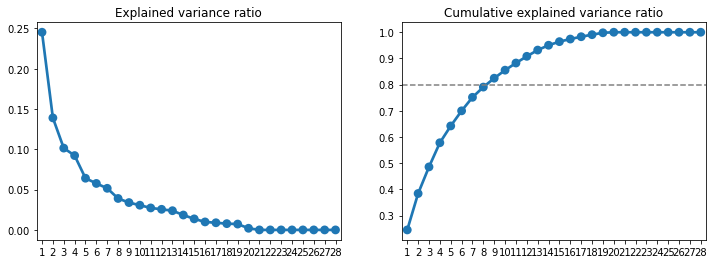

In [42]:
fig, ax = plt.subplots(1,2,figsize=(12, 4))
sns.pointplot(x=np.arange(1,29,1),y=pca.explained_variance_ratio_,ax=ax[0])
sns.pointplot(x=np.arange(1,29,1),y=np.cumsum(pca.explained_variance_ratio_),ax=ax[1])
ax[0].set_title('Explained variance ratio')
ax[1].set_title('Cumulative explained variance ratio')
ax[1].axhline(0.8,ls='--',color='gray')

### Every principal component is essentially a linear combination of the features. By taking a look at first two principal components, we may have a brief idea which features are playing a important role in variance explanation. In general, the numerical features are doing a better job than the categorical features (after being encoded) as they have higher variety in terms of the value. 

Text(0.5, 1.0, 'Second principal component')

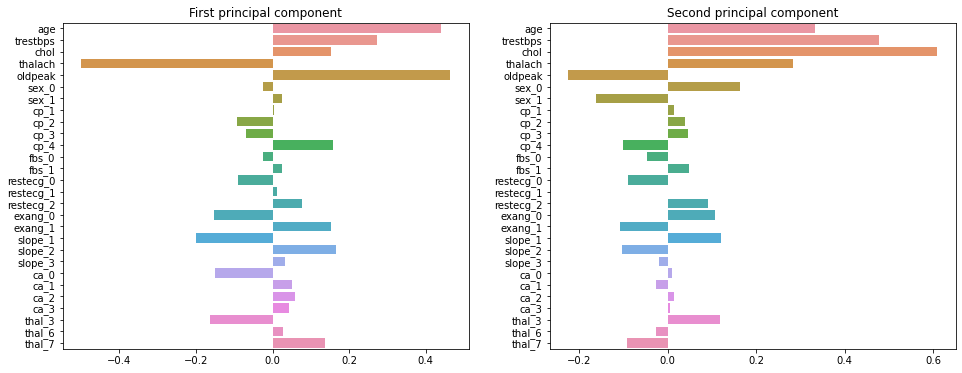

In [43]:
fig, ax = plt.subplots(1,2,figsize=(16, 6))
sns.barplot(x=pca.components_[0],y=X.columns,orient='h',ax=ax[0])
sns.barplot(x=pca.components_[1],y=X.columns,orient='h',ax=ax[1])
ax[0].set_title('First principal component')
ax[1].set_title('Second principal component')

### We do a PCA transform on the data to express each data point in terms of the principal components. 

In [44]:
X_latents = pca.transform(X)
X_latents = pd.DataFrame(X_latents,columns=[f'dim_{i+1}' for i in range(X_latents.shape[1])])
X_latents.head()

,dim_1,dim_2,dim_3,dim_4,dim_5,dim_6,dim_7,dim_8,dim_9,dim_10,...,dim_19,dim_20,dim_21,dim_22,dim_23,dim_24,dim_25,dim_26,dim_27,dim_28
0,1.087992,0.372638,-1.271275,-0.240135,0.576431,-0.856537,-0.603891,-0.614801,-0.541453,-0.245773,...,0.052113,-0.075043,9.032009e-17,4.623663e-16,-6.156306e-16,-2.200081e-16,1.110223e-16,2.220446e-16,3.053113e-16,-4.440892e-16
1,2.813771,0.807979,0.120024,-0.558623,-0.570164,0.825947,-0.571407,0.003537,-0.490289,-0.185441,...,0.278862,-0.070927,2.429758e-16,1.440445e-16,7.565670e-17,3.802062e-16,5.551115e-17,-5.551115e-17,-3.469447e-16,4.440892e-16
2,2.329030,-1.089585,0.474496,-0.027767,0.031975,-1.028541,-0.443364,0.631092,0.359245,-0.250978,...,0.027769,0.006160,1.666479e-16,5.644097e-17,-3.273221e-18,6.101709e-17,1.387779e-17,5.551115e-17,2.775558e-17,1.665335e-16
3,-1.163143,-0.662409,-1.579279,2.340236,1.617635,-0.380933,0.506575,-0.384098,-0.565434,0.351726,...,0.623184,-0.051438,-1.029387e-17,3.782322e-16,7.392197e-17,2.632262e-17,1.110223e-16,-3.053113e-16,-1.040834e-16,5.551115e-17
4,-1.749042,-0.197127,-0.929031,0.555730,0.824813,0.459967,-0.946655,0.539861,-0.350032,-0.043926,...,-0.297911,-0.039372,3.782842e-16,5.210416e-17,-9.344753e-18,2.632262e-17,5.551115e-17,2.775558e-16,1.110223e-16,0.000000e+00


### The next question we may have is whether we can make use of the transformed data to enhance the prediction result.  If we look at the feature after transformation by the first principal component ("dim_1"),  the samples of class 1 in general have larger value in "dim_1". For the transformed feature by the second principal component ("dim_2"), it shows a unclear boundary between two classes, with class 1 slightly smaller value. 

<AxesSubplot:xlabel='dim_2', ylabel='target'>

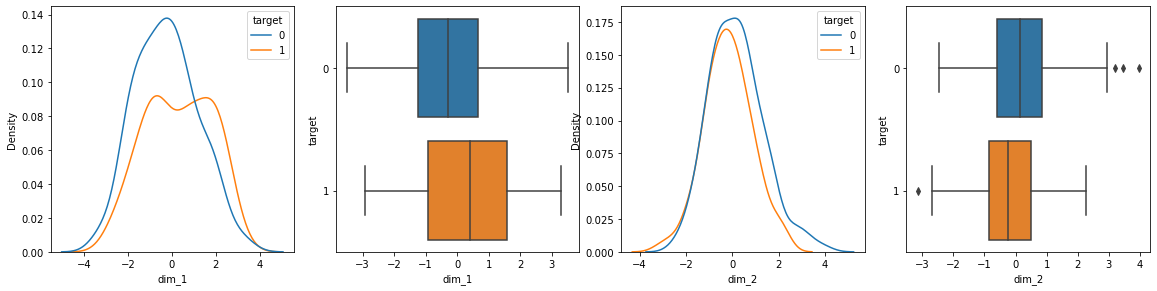

In [45]:
fig, ax = plt.subplots(1,4,figsize=(16, 4))
fig.tight_layout()
sns.kdeplot(x='dim_1',hue=y.astype('category'),data=X_latents,ax=ax[0])
sns.boxplot(x='dim_1',y=y.astype('category'),data=X_latents,ax=ax[1])
sns.kdeplot(x='dim_2',hue=y.astype('category'),data=X_latents,ax=ax[2])
sns.boxplot(x='dim_2',y=y.astype('category'),data=X_latents,ax=ax[3])

### Now we want to see how much the prediction accuracy could be improved as we keep adding latent dimensions to the input for the model. We will use a neural network model here and start with only one latent dimension. 

### The following experiment may take 10 mins to complete. It is advised to skip the process and retrieve the results directly from the csv file (by setting variable 'skip' as True).

In [46]:
skip = True

In [47]:
if skip:
    nn_pca_df = pd.read_csv('./data/nn_pca_df.csv')
else:
    set_seed(1)
    np.random.seed(1)
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    nn_pca_df=[]
    for k in range(X_latents.shape[1]):
        print('.',end="")
        f1_nn_pca_train=[]
        f1_nn_pca_test=[]
        for idx, (train_index, test_index) in enumerate(kf.split(X_latents,y)):

            X_train, X_test = X_latents.iloc[train_index,:k+1], X_latents.iloc[test_index,:k+1]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]

            nn = Sequential()
            nn.add(Dense(units=32, input_dim=X_train.shape[1], activation='relu', kernel_initializer='uniform',bias_initializer='zeros'))
            nn.add(Dense(units=64, activation='relu', kernel_initializer='uniform',bias_initializer='zeros'))
            nn.add(Dense(units=128, activation='relu', kernel_initializer='uniform',bias_initializer='zeros'))
            nn.add(Dense(units=1, activation='sigmoid', kernel_initializer='uniform',bias_initializer='zeros'))
            nn.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

            history = nn.fit(X_train,y_train,epochs=100,batch_size=32,validation_split=0.2,callbacks=EarlyStopping(monitor = 'val_loss',patience = 10),verbose=0)

            y_train_pred = np.round(nn.predict(X_train))
            y_test_pred = np.round(nn.predict(X_test))

            f1_train = f1_score(y_train,y_train_pred,average=None)
            f1_test = f1_score(y_test,y_test_pred,average=None)

            f1_nn_pca_train.append(f1_train)
            f1_nn_pca_test.append(f1_test)

        nn_pca_df.append(np.hstack((k+1,np.mean(f1_nn_pca_train,0),np.mean(f1_nn_pca_test,0))))
    nn_pca_df = pd.DataFrame(nn_pca_df,columns=['n_dims','F1_train_0','F1_train_1','F1_test_0','F1_test_1'])
    nn_pca_df.to_csv('./data/nn_pca_df.csv',index=False)
    print('|',end="")

In [48]:
nn_pca_df.head()

,n_dims,F1_train_0,F1_train_1,F1_test_0,F1_test_1
0,1.0,0.790249,0.741705,0.783974,0.731354
1,2.0,0.805675,0.760211,0.807835,0.762960
2,3.0,0.813369,0.769522,0.810259,0.767750
3,4.0,0.835475,0.781498,0.813763,0.752669
4,5.0,0.862273,0.820799,0.828016,0.772576


### The chart below shows the trend of F1 score for training and test data with respect to two classes. As we increases the latent dimension, F1 score grows steadily until we reach latent dimension around 12. For train F1 score, it keeps growing and then flattens out when we continue increasing the latent dimension. However, test F1 score will reach a local maximum and drops gently afterwards. Therefore, we know that the overfitting issue occurs when we include too many latent dimensions (typically >=18). 

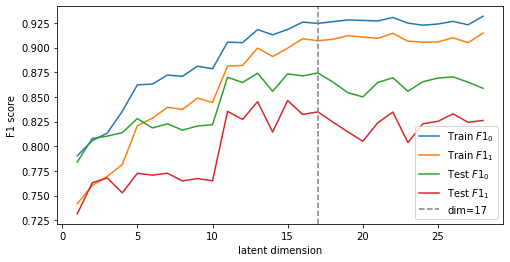

In [49]:
fig, ax = plt.subplots(figsize=(8, 4))
sns.lineplot(x='n_dims',y='F1_train_0',data=nn_pca_df,label="Train $F1_0$")
sns.lineplot(x='n_dims',y='F1_train_1',data=nn_pca_df,label="Train $F1_1$")
sns.lineplot(x='n_dims',y='F1_test_0',data=nn_pca_df,label="Test $F1_0$")
sns.lineplot(x='n_dims',y='F1_test_1',data=nn_pca_df,label="Test $F1_1$")
ax.set_xlabel('latent dimension')
ax.set_ylabel('F1 score')
ax.axvline(17,ls='--',color='gray',label='dim=17')
ax.legend()

### Previously, we used a neural network model to predict the output and its F1 scores for class 0 and 1 are 0.854, 0.816 respectively. After using PCA like a data pre-processing step and restricted to first 17 principal components, we are able to get a slightly better result, 0.874 and 0.835.

In [50]:
nn_pca_df[nn_pca_df.n_dims==17]

,n_dims,F1_train_0,F1_train_1,F1_test_0,F1_test_1
16,17.0,0.924527,0.906983,0.87433,0.834825


## Data Clustering $-$ K-means

### It is intuitive that the samples with similar features should have similar output. We can actually cluster the samples into several groups and we expect that the output of samples from a same group should be consistent. This can be realized by K-means clustering. 

### We use scaled one-hot encoded dataset for K-means clustering because the algorithm depends heavily on the distance calculation. For a binary classification problem, we will intuitively set $K=2$ and see if we can use the clustering result to do the prediction.

In [51]:
X_col = list(heart_scaled.columns)
X_col.remove('target')
X = heart_scaled[X_col]
y = heart_scaled['target']

In [52]:
kmeans = KMeans(n_clusters=2,random_state=1)
kmeans.fit(X)
X_cluster = kmeans.predict(X)

### If we directly use the clustering result to predict the output class, for each cluster, we just choose the class which most samples belong to (majority voting). The F1 score is relatively low for both classes (0.781,0.745). However, we can still tell that the data points from same class tend to cluster closer. This means the patients with heart disease have some common or similar symptons. 

In [53]:
ct = pd.crosstab(y,X_cluster)
ct

col_0,0,1
target,,
0,125,35
1,35,102


In [54]:
cluster_class = dict(ct.idxmax())
cluster_class

{0: 0, 1: 1}

In [55]:
y_pred_km = [cluster_class[x] for x in X_cluster]
f1_score(y,y_pred_km,average=None)

array([0.78125   , 0.74452555])

### Now we will try increasing the number of clusters, $K$. By doing this, we expect our prediction would be more accurate on the training data. Having said that, to get an accurate prediction on test data, we cannot have too many clusters. Imagine that an extreme scenario would be every data point forms a cluster by itself. Then the clustering problem becomes K-Nearest Neighbours (KNN) with $K=1$. This leads to a genuinely overfitting model and will possibly not produce a good prediction result.

### Next, we will iterate $K$ from 2 to 50 and calculate average F1 scores using 5-fold cross validation. For each $K$, we will repeat for 10 times as the clustering result highly depends on the initialization. The following experiment may take 10 mins to complete. It is advised to skip the process and retrieve the results directly from the csv file (by setting variable 'skip' as True).

In [56]:
skip = True

In [57]:
def KMeansPredict(k=2,rs=1):
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    f1_km_train=[]
    f1_km_test=[]
    for idx, (train_index, test_index) in enumerate(kf.split(X,y)):

        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        kmeans_k = KMeans(n_clusters=k,random_state=rs)
        kmeans_k.fit(X_train)

        X_cluster_train = kmeans_k.predict(X_train)
        ct_train = pd.crosstab(y_train,X_cluster_train)
        cluster_class_train = dict(ct_train.idxmax())
        y_pred_train = np.vectorize(cluster_class_train.get)(X_cluster_train)
        f1_train = f1_score(y_train,y_pred_train,average=None)

        X_cluster_test = kmeans_k.predict(X_test)
        y_pred_test = np.vectorize(cluster_class_train.get)(X_cluster_test)
        f1_test = f1_score(y_test,y_pred_test,average=None)        

        f1_km_train.append(f1_train)
        f1_km_test.append(f1_test)
        
    return np.hstack((k,np.mean(f1_km_train,0),np.mean(f1_km_test,0)))

In [58]:
if skip:
    kmeans_df = pd.read_csv('./data/kmeans_df.csv')
else:
    kmeans_df = [np.mean([KMeansPredict(k,rs) for rs in range(10)],0) for k in range(2,51)]
    kmeans_df = pd.DataFrame(kmeans_df,columns=['K','F1_train_0','F1_train_1','F1_test_0','F1_test_1'])
    kmeans_df.to_csv('./data/kmeans_df.csv',index=False)

In [59]:
kmeans_df.head()

,K,F1_train_0,F1_train_1,F1_test_0,F1_test_1
0,2.0,0.787488,0.747846,0.781928,0.738491
1,3.0,0.805204,0.720849,0.784924,0.693466
2,4.0,0.796459,0.745263,0.790363,0.732815
3,5.0,0.807306,0.732786,0.793622,0.714792
4,6.0,0.805666,0.732071,0.790993,0.709945


### The train F1 score for both classes keeps increasing as we expected. But the test F1 score reaches the maximum at $K=12$.

### If we smoothen the curves by calculating the rolling average with a window size =5 and triangle window type, the trend becomes clearer where the test F1 score could be optimized at $K$ typically between 12 and 17.

In [60]:
kmeans_df['F1_train_0_rolling_avg'] = kmeans_df.rolling(5, center=True, min_periods=1, win_type='triang').mean().F1_train_0
kmeans_df['F1_train_1_rolling_avg'] = kmeans_df.rolling(5, center=True, min_periods=1, win_type='triang').mean().F1_train_1
kmeans_df['F1_test_0_rolling_avg'] = kmeans_df.rolling(5, center=True, min_periods=1, win_type='triang').mean().F1_test_0
kmeans_df['F1_test_1_rolling_avg'] = kmeans_df.rolling(5, center=True, min_periods=1, win_type='triang').mean().F1_test_1

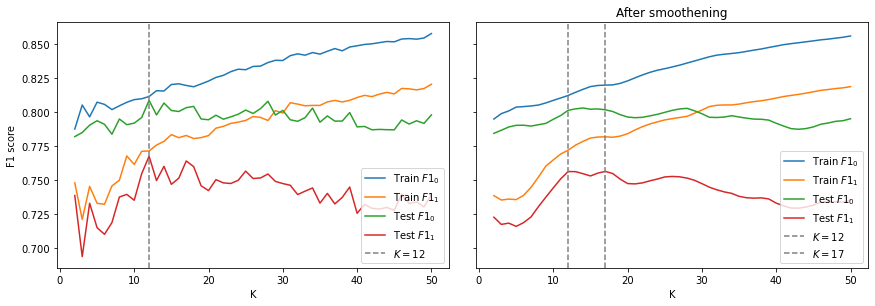

In [61]:
fig, ax = plt.subplots(1,2,figsize=(12, 4),sharey=True)
fig.tight_layout()

sns.lineplot(x='K',y='F1_train_0',data=kmeans_df,label="Train $F1_0$",ax=ax[0])
sns.lineplot(x='K',y='F1_train_1',data=kmeans_df,label="Train $F1_1$",ax=ax[0])
sns.lineplot(x='K',y='F1_test_0',data=kmeans_df,label="Test $F1_0$",ax=ax[0])
sns.lineplot(x='K',y='F1_test_1',data=kmeans_df,label="Test $F1_1$",ax=ax[0])
ax[0].set_xlabel('K')
ax[0].set_ylabel('F1 score')
ax[0].axvline(12,ls='--',color='gray',label='$K=12$')
ax[0].legend()

sns.lineplot(x='K',y='F1_train_0_rolling_avg',data=kmeans_df,label="Train $F1_0$",ax=ax[1])
sns.lineplot(x='K',y='F1_train_1_rolling_avg',data=kmeans_df,label="Train $F1_1$",ax=ax[1])
sns.lineplot(x='K',y='F1_test_0_rolling_avg',data=kmeans_df,label="Test $F1_0$",ax=ax[1])
sns.lineplot(x='K',y='F1_test_1_rolling_avg',data=kmeans_df,label="Test $F1_1$",ax=ax[1])
ax[1].set_xlabel('K')
ax[1].set_ylabel('F1 score')
ax[1].set_title('After smoothening')
ax[1].axvline(12,ls='--',color='gray',label='$K=12$')
ax[1].axvline(17,ls='--',color='gray',label='$K=17$')
ax[1].legend()

### Using clustering result to predict the output, the test F1 score for two classes is 0.809 and 0.767. 

In [62]:
kmeans_df[kmeans_df.K==12]

,K,F1_train_0,F1_train_1,F1_test_0,F1_test_1,F1_train_0_rolling_avg,F1_train_1_rolling_avg,F1_test_0_rolling_avg,F1_test_1_rolling_avg
10,12.0,0.811461,0.771377,0.808577,0.767499,0.81225,0.771939,0.801331,0.756176


## Conclusions

### The test F1 score for two classes has been tabulated below. As we can see, if we combine PCA and neural network, we will achieve the best classification result. Having said that, all the supervised learning models adopted in fact show a similar classification performance. We have also experimented using K-means clustering with majority voting practice as a classifier, from which we can tell the samples from same class share similarity to some extent. 

|Model|Test F1_0|Test F1_1|
|:-:|:-:|:-:|
|Logistic regression|0.869|0.835|
|Random forest|0.861|0.824|
|Neural network|0.854|0.816|
|PCA + Neural network|0.874|0.835|
|K-means (abused)|0.809|0.767|